# ECON526: Quantitative Economics with Data Science Applications

Latent Variables and Introduction to Unsupervised Learning

Jesse Perla (University of British Columbia)

# Overview

## Motivation and Materials

-   In this lecture, we will continue with some applications of the
    tools we developed in the previous lectures
-   We introduce [scikit-learn](https://scikit-learn.org/stable/), a
    package for old-school (i.e. not deep learning or neural networks)
    ML and data analysis
    -   Introduces “unsupervised learning” (i.e., tools to interpret
        data structure without any forecasts/predictions)

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from scipy.linalg import solve_triangular, eigvalsh, cholesky
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

<frozen importlib._bootstrap>:228: RuntimeWarning:

scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Latent Variables

## Features, Labels, and Latents

-   Data science and ML often use different terminology than economists:
    -   **Features** are economists **explanatory or independent
        variables**. They have the key source of variation to make
        predictions and conduct counterfactuals
    -   **Labels** correspond to economists **observables or dependent
        variables**
    -   **Latent Variables** are **unobserved variables**, typically
        sources of heterogeneity or which may drive both the dependent
        and independent variables
-   Economists will use theory and experience to transform data (i.e.,
    what ML people call “feature engineering”) for better explanatory
    power or map to theoretical models

## Unsupervised Learning

-   ML refers to methods using only **features** as **unsupervised
    learning**. The structure of the underlying data can teach you about
    its data generating process
-   **Key:** uncover and interpret latent variables using statistics
    coupled with assumptions from economic theory. There is theory
    beyond all interpretation

# Principle Components

## Principle Components and Factor Analysis

-   Another application of eigenvalues is dimension reduction, which
    simplifies **features** by uncovering **latent** variables.
    Unsupervised
-   One technique is Principle Components Analysis (PCA), which uncovers
    latent variables that capture the primary directions of variation in
    the underlying data
    -   May allow mapping data into a lower-dimensional, uncorrelated
        features
    -   Uses Singular Value Decomposition (SVD) - a generalization of
        eigendecomposition to non-square matrices
-   Given a matrix $X \in \mathbb{R}^{N \times M}$, can we find a
    lower-dimensional representation $Z \in \mathbb{R}^{N \times L}$ for
    $L < M$ that captures the most variation in $X$?
-   The goal is to invert the $X$ data to find the $Z$—and provide a
    mapping to reduce the dimensionality for future data.

## Singular Value Decomposition

-   Many applications of SVD (e.g., least squares, checking rank), in
    part because it is especially “numerically stable” (i.e., not
    sensitive to the roundoff errors we talked about previously)
-   One application is to find the latent variables in PCA
-   PCA can be interpreted with an
    [eigendecomposition](https://python.quantecon.org/svd_intro.html#application-principal-components-analysis-pca),
    but can be more confusing than just using the SVD directly.

## SVD

An SVD for any $X \in \mathbb{R}^{N\times M}$ is:

$$
X = U \Sigma V^T
$$

-   The diagonal elements of $\Sigma \in \mathbb{R}^{N\times M}$ are
    singular values, and there are zeros everywhere else. If $M < N$
    then there $M$ singular values ($\sigma_1, \ldots \sigma_M$)
    -   Those singular values are also the square roots of the
        eigenvalues of $X X^T$ (or $X^T X$)
    -   The number of non-zero singular values is the rank of the matrix
        $X$
-   $U\in\mathbb{R}^{N\times N}$ and $V \in \mathbb{R}^{M \times M}$ are
    orthogonal matrices
    -   $U$ is eigenvectors of $X X^T$ and $V$ is eigenvectors of
        $X^T X$

## Decomposing the Data

A key result is that we can decompose the data into a sum of outer
products of the eigenvectors and singular values. Assume ordered so that
$\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_M$: $$
X = U \Sigma V^T = \sum_{m=1}^M \sigma_m u_m v_m^T
$$

Where here we assumed that the $\text{rank}(X) \leq M$ and

-   $u_m \in\mathbb{R}^N$ is the $m$-th column of $U$ and
    $v_m \in\mathbb{R}^M$ is the $m$th column of $V$
-   So $u_m v_m^T$ is an $N \times M$ matrix but you can show that it is
    rank-1. i.e., you can decompose it into the product of two vectors.

## Interpreting Rank

-   Intuition: rank $r$ if it can be decomposed into the sum of $r$
    rank-1 matrices
    -   Alternatively, can interpret rank of an $N \times M$ matrix is
        $3$ if can find a $A \in \mathbb{R}^{N \times 3}$ and
        $B \in \mathbb{R}^{3 \times M}$ such that $X = A B$
-   Remember: this works for **any** matrix
    $X \in \mathbb{R}^{N \times M}$

## Dimension Reduction

-   Frequently $\sigma_1 \gg \sigma_M$ and the $\sigma_m$ may decay
    quickly, so we can approximate $X$ with fewer terms by truncating
    the sum at $L < M$.

$$
X \approx \sum_{m=1}^L \sigma_m u_m v_m^T
$$

-   Note that if the data is actually lower-dimensional in a suitable
    space (e.g., $\text{rank}(X) = L < M$) then $\sigma_m = 0$ for
    $L < m \leq M$, so the truncated sum is exact

## PCA as an Optimal Dimension Reduction

-   Can prove that if we truncate at $L < M$, this is the best rank $L$
    approximation to $X$ according to some formal criteria.
    -   Intuitively, finds directions of the data that capture the most
        variation in the covariance matrix
    -   Can prove it is the solution to the optimization problem to
        explain the most variation in the data with the lowest
        dimensionality

See
[here](https://en.wikipedia.org/wiki/Principal_component_analysis#First_component)
for some intuition on this as an optimization problem.

## Creating a Dataset with Latent Factors

Create a dataset with two latent factors, the first dominating

In [2]:
N = 50 # number of observations
L, M = 2, 3 # number of latent and observed factors
Z = np.random.randn(N, L) # latent factors
F = np.array([[1.0, 0.05], # X_1 = Z_1 + 0.05 Z_2
              [2.0, 0.0], # X_2 = 2 Z_1
              [3.0, 0.1]]) # X_3 = 3 Z_1 + 0.1 Z_2
X = Z @ F.T + 0.1 * np.random.randn(N, M) # added noise
print(f"Z is {Z.shape}, X is {X.shape}")

Z is (50, 2), X is (50, 3)

## PCA Without Dimension Reduction

-   See [QuantEcon SVD](https://python.quantecon.org/svd_intro.html) for
    coding yourself. We will use the
    [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
    package
-   The explained variance is the fraction of the variance explained by
    each factor

In [3]:
pca = PCA(n_components=3)
pca.fit(X)
with np.printoptions(precision=4, suppress=True, threshold=5):
  print(f"Singular Values (sqrt eigenvalues):\n{pca.singular_values_}")
  print(f"Explained Variance (ordered):\n{pca.explained_variance_ratio_}")

Singular Values (sqrt eigenvalues):
[25.677   0.7806  0.6292]
Explained Variance (ordered):
[0.9985 0.0009 0.0006]

## Dimension Reduction with PCA

In [4]:
pca = PCA(n_components=2) # one less, and correctly specified
Z_hat = pca.fit_transform(X) # transformed by dropping last factor 
# Scale and sign may not match due to indeterminacy
print(f"Correlation of Z_1 to Z_hat_1 = {np.corrcoef(Z.T, Z_hat.T)[0,2]}")
print(f"Correlation of Z_2 to Z_hat_2 = {np.corrcoef(Z.T, Z_hat.T)[1,3]}")

Correlation of Z_1 to Z_hat_1 = 0.9994499183581406
Correlation of Z_2 to Z_hat_2 = -0.49269200731464263

## Interpreting the Results

-   The first factor in the decomposition is nearly perfectly (positive
    or negatively) correlated with the more important latent factor
    -   The sign could have gone either way. The key is the shared
        information
    -   How could you have known the sign is indeterminate?
-   The 2nd factor has a good but not great correlation with the 2nd
    latent. Why?
-   The variance decomposition that gave a 3rd factor with non-zero
    variance
    -   We only had two latent variables. Why didn’t it figure it out?
-   How could you have changed the DGP to make this **less** successful?

## Warning

-   We have just scratched the surface to build some intuition.
-   Many missing details and caveats (e.g., you may want to rescale your
    data, make sure everything is demeaned if implementing yourself,
    etc.)
-   Read up on the documentation and theory before using in practice
-   Many
    [generalizations](https://en.wikipedia.org/wiki/Principal_component_analysis#Generalizations)
    exist which are more appropriate in particular settings

# Auto-Encoders

## Auto-Encoders and Dimensionality Reduction

-   General class of problems which they call auto-encoders in ML/data
    science
    -   Function $f$, the encoder, maps $X$ to a latent space $Z$, which
        may be lower-dimensional
    -   Function $g$, the decoder, maps points in the latent space $Z$
        back to $X$
    -   $\theta_e$ and $\theta_d$ are parameters for $f$ and $g$ which
        we are trying to find
-   Then the goal is to find the $\theta_e$ and $\theta_d$ parameters
    for our encoder, $f$, and decoder, $g$, where for as many $X$ as
    possible we have

$$
g(f(x; \theta_e); \theta_d) \approx x
$$

-   The $z = f(x;\theta_e)$ may be lower-dimensional, but may be useful
    regardless

## Optimization Problem for an Auto-encoder

-   If we had a distribution for $x$ then can solve

    $$
    \min_{\theta_e, \theta_d} \mathbb{E}||g(f(x; \theta_e); \theta_d) - x||_2^2
    $$

-   But typically in practice we replace expectation with empirical
    distribution $\{x_1,\ldots x_N\}$

$$
\min_{\theta_e, \theta_d} \frac{1}{N} \sum_{n=1}^N ||g(f(x_n; \theta_e); \theta_d) - x_n||_2^2
$$

## PCA as a Linear Auto-Encoder

-   Let $f(x) = W^T x$ and $g(z) = W z$ where
    $W \in \mathbb{R}^{M \times L}$. If $\hat{x} \approx W W^T x$,
    “reconstruction error” is $||\hat{x} - x||_2^2$.

$$
\min_{W} \frac{1}{N} \sum_{n=1}^N ||W \overbrace{W^T x_n}^{z_n = f(x_n;W)} - x_n||_2^2,\quad \text{with } W^T W = I
$$

-   Can show gives equivalent to PCA! For fixed $L$ latent space size,
    $W$ are the first $L$ columns of $V$ from the SVD (sorted by size of
    singular values)

-   In more advanced machine learning examples, intuition seems to come
    up frequently. Related to embeddings, which come up with NLP,
    networks, etc.

# Discrete Latent Variables

## Discrete Latent Variables

-   PCA was a way to uncover continuous latent variables or find
    low-dimensional continuous approximations
-   But latent variables may be discrete (e.g., types of people, firms)
-   Hidden discrete variables require assigning observations to groups

## Clustering

-   Clustering lets you take a set of observations with (potentially)
    variables (i.e., features) and try to assign a discrete latent
    variable to each observation
    -   Theory may or may not help us know the number of groups
    -   While some are statistical and probabilistic, most methods
        assign a single latent type rather than a distribution
    -   Choosing the number of groups to assign to is a challenge that
        requires theory and regularization - which we will avoid here
    -   Instead, just as with PCA we will choose the number of groups
        ad-hoc rather than in a disciplined way

## Partitioning Sets

-   Let $X\in\mathbb{R}^{N\times M}$ with
    $x_1,\ldots x_N\in\mathbb{R}^M$ the individual observations
-   Assume that each $x_n$ has a latent discrete $k \in \{1, \ldots K\}$
    then we can assign each observation to one group
    -   $\mathbf{S} \equiv \{S_1, \ldots, S_K\}$ where each
        $n=1,\ldots N$ is in exactly one $S_k$ (i.e. a partition)
-   The goal is to find the partition which is the most likely to assign
    each $x_n$ the correct latent variable $k$
-   An alternative interpretation is to think of this as a
    dimension-reduction technique that reduces complicated data into a
    low-dimensional discrete variable
-   In economics, we will sometimes cluster on some observations to
    reduce the dimension, then leave others continuous

## k-means Clustering

-   Consider if the $n\in S_k$ with should have similar $x_n$
    -   Group observations that are close or similar to each other
    -   As always in linear algebra, close suggests using a norm. The
        Euclidean norm in the $M$ dimensional feature space is a good
        baseline
-   Objective function of k-means: choose the partition $\mathbf{S}$
    which minimizes the norm between observations within each group
    -   Normalize by group size $|S_k|$ to avoid distorting the
        objective function due to different group sizes

## Formal Optimization Problem

-   Formally,

    $$
    \min_{\mathbf{S}} \sum_{k=1}^K \frac{1}{|S_k|}\sum_{x_n, x_{n'} \in S_k} ||x_n - x_{n'}||_2^2
    $$

-   Using standard Euclidean norm between two elements in $S_k$ $$
    ||x_n - x_{n'}||_2^2 = \sum_{m=1}^M (x_{nm} - x_{n'm})^2
    $$

## k-means Objective Function

-   Can prove that the previous objective is equivalent to minimizing
    the sum of the squared distances from the group $k$’s mean

    $$
    \min_{\mathbf{S}} \sum_{k=1}^K \sum_{n \in S_k} ||x_n - \bar{x}_k||_2^2
    $$

-   Where the mean of group $k$ is standard, and across all $m$ features

    $$
    \bar{x}_k \equiv \frac{1}{|S_k|}\sum_{x_n \in S_k} x_n
    $$

-   Avoid different scales so $\bar{x}_k$ isn’t dominated by one feature

## Generating Data with Latent Groups

-   Generate data with 2 features and 2 latent groups and see how
    k-means does
-   First, put the data in a dataframe

In [5]:
mu_1 = np.array([0.0, 0.0]) # mean of k=1
mu_2 = np.array([1.0, 1.0]) # mean of k=2
sigma = np.array([[0.2, 0], [0, 0.2]]) # use same variance
N = 100 # observations
X_1 = np.random.multivariate_normal(mu_1, sigma, N)
X_2 = np.random.multivariate_normal(mu_2, sigma, N)
df_1 = pd.DataFrame({"f1": X_1[:, 0], "f2": X_1[:, 1], "k": 1})
df_2 = pd.DataFrame({"f1": X_2[:, 0], "f2": X_2[:, 1], "k": 2})
df = pd.concat([df_1, df_2], ignore_index=True)

## Plotting Code with Seaborn

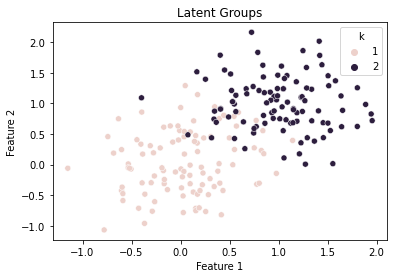

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="f1", y="f2",
  hue="k", ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2",
  title="Latent Groups")
plt.show()

## k-means to Recover the Latent Groups

-   Run k-means with 2 clusters and check the results
-   If correlation is close to 1 then successfully recovered the latent
    groups
-   If the correlation is close to -1 then it was successful. The latent
    groups $\hat{k}$ numbers are ordered arbitrarily, just as $k$ was

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0)
k_hat = kmeans.fit_predict(df[["f1", "f2"]])
df["k_hat"] = k_hat + 1
corr = df["k"].corr(df["k_hat"])
print(f"Correlation between k and k_hat:{corr:.2f}")

Correlation between k and k_hat:-0.82

## Confusion Matrix

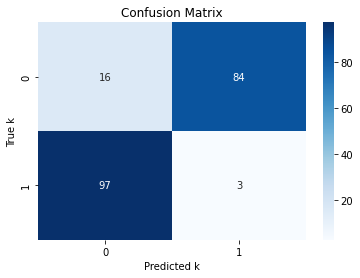

In [8]:
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm = confusion_matrix(df["k"], df["k_hat"])

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted k')
plt.ylabel('True k')
plt.title('Confusion Matrix')
plt.show()

## Potentially Swap $\hat{k}$ and Compare

Label ordering arbitary, so “confusion matrix might require reordering
to compare

In [9]:
if df['k'].corr(df['k_hat']) < 0.5:
  df['k_hat'] = df['k_hat'].replace({1: 2, 2: 1})
  print(f"Correlation now {df['k'].corr(df['k_hat'])}")

df['Cluster'] = df.apply(lambda x: rf"$k=\hat{{k}}={{{x['k']:.0g}}}$"
                         if x['k'] == x['k_hat'] else r'$k \neq \hat{k}$',
                         axis=1)

Correlation now 0.8169324941698154

## Plotting the Uncovered Latent Groups

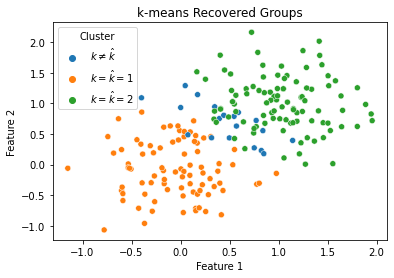

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, x="f1", y="f2",
  hue="Cluster", ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2",\
       title="k-means Recovered Groups")
plt.show()

# (Optional) Factors within a Portfolio Model

## Simulation

In the previous lecture we introduced code for simulation

In [11]:
def simulate(A, X_0, T):
    X = np.zeros((2, T+1))
    X[:,0] = X_0
    for t in range(T):
        X[:,t+1] = A @ X[:,t]
    return X

## A Portfolio Example

-   Two assets pay dividends
    $d_t \equiv \begin{bmatrix} d_{1t} & d_{2t} \end{bmatrix}^T$
    following $d_{t+1} = A\, d_t$ from $d_0$
-   Portfolio has $G \equiv \begin{bmatrix} G_1 & G_2 \end{bmatrix}$
    shares of each asset and you discount at rate $\beta$

In [12]:
A = np.array([[0.6619469, 0.49646018],[0.5840708, 0.4380531]])
G = np.array([[10.0, 4.0]])       
d_0 = np.array([1.0, 1.0])
T, beta = 10, 0.9
p_0 = G @ solve(np.eye(2) - beta * A, d_0)
d = simulate(A, d_0, T)
y = G @ d # total dividends from portfolio
print(f"Portfolio value at t=0 is {p_0[0]:.5g}, total dividends at time {T} is {y[0,T]:.5g}")

Portfolio value at t=0 is 1424.5, total dividends at time 10 is 36.955

## Dividends Seem to Grow at a Similar Rate?

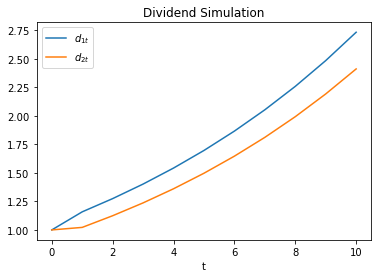

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), d.T, label=[r"$d_{1t}$", r"$d_{2t}$"])
ax.set(xlabel="t", title="Dividend Simulation")
ax.legend()
plt.show()

## Digging Deeper

-   Let’s do an eigendecomposition to analyze the factors

In [14]:
Lambda, Q = eig(A)
print(np.real(Lambda))

[ 1.10000000e+00 -2.65486733e-09]

-   The first eigenvector is 1.1, but the second is very close to zero!
    -   (In fact, I rigged it to be zero by constructing from a
        $\Lambda$, so this is all numerical copy/paste errors)
-   Suggests that maybe only one latent factor driving both $d_{1t}$ and
    $d_{2t}$?
-   Of course, you may have noticed that the columns in the matrix
    looked collinear, which was another clue.

## Evolution Matrix is Very Simple with $\lambda_2 = 0$

If we stack columns $Q \equiv \begin {bmatrix} q_1 & q_2 \end{bmatrix}$
then, $$
A = Q \Lambda Q^{-1} = Q \begin{bmatrix} \lambda_1 & 0 \\ 0 & 0 \end{bmatrix} Q^{-1} = \lambda_1 q_1  q_1^{-1}
$$

In [15]:
lambda_1 = np.real(Lambda[0])
q_1 = np.reshape(Q[:,0], (2,1))
q_1_inv = np.reshape(inv(Q)[0,:], (1,2))
norm(A - lambda_1 * q_1 @ q_1_inv) # pretty close to zero!

2.663274500543771e-09

## Transforming to the Latent State

-   Recall: $A = Q \Lambda Q^{-1}$ can be interpreted as:
    -   Transformation to latent space, scaling, transform back
-   We can demonstrate this in our example:
    -   Transforming $d_0$ to $\ell_0$ using $q_1^{-1}$
    -   Evolving $\ell_t$ from $\ell_0$ with
        $\ell_{t+1} = \lambda_1 \ell_t$, or
        $\ell_t = \lambda_1^t \ell_0$
    -   Transforming back with $q_1$
    -   Checking if it aligns with the $d_t$

## Implementation

In [16]:
l_0 = lambda_1 * q_1_inv @ d_0 # latent space
l = l_0 * np.power(lambda_1, np.arange(0, T)) # powers
d_hat = q_1 * l # back to original space
# Missing d_0 since doing A * d_0 iterations
print(f"norm = {norm(d[:,1:] - d_hat)}")
y_hat = G @ d_hat

norm = 2.3494410875961204e-10

Let’s see if these line up perfectly

## Total Dividends and the Latent Variable

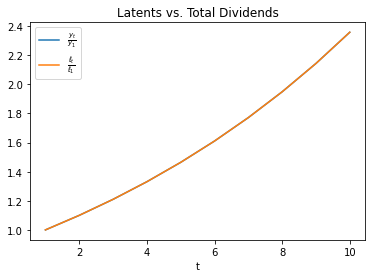

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
data = np.vstack((y_hat / y_hat[:,0], l / l[0]))
ax.plot(range(1, T+1), data.T, label=[r"$\frac{y_t}{y_1}$", r"$\frac{\ell_t}{\ell_1}$"])
ax.set(xlabel="t", title="Latents vs. Total Dividends")
ax.legend()
plt.show()